<a href="https://colab.research.google.com/github/harshkp20/ECO765/blob/master/harshkp20/ECO765/Codes/Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Libraries

In [314]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

# **Question 1**

10 vectors with mean [1 0]

In [315]:
mean1 = [1,0]
var1 = [[1,0], [0,1]]
N1=10
set1 = np.random.multivariate_normal(mean1,var1,N1)

10 Vectors with mean [0 1]

In [316]:
mean2 = [0,1]
var2 = [[1,0], [0,1]]
N2=10
set2 = np.random.multivariate_normal(mean2,var2,N2)

Generation of first set of 100 feature vectors

In [317]:
cov1_1=[[0.1,0],[0,0.1]]
N3=10
set1_1 =[]
for i in range(0,10):
  set1_1.append(np.random.multivariate_normal(set1[i], cov1_1,N3))

Reshaping

In [318]:
data1=np.array(set1_1)
data1=data1.reshape(100,2)

Making DataFrame

In [319]:
df1 = pd.DataFrame(data1,columns=['feature1', 'feature2'])
df1['y']=1

Generation of second set of 100 feature vectors

In [320]:
cov2_1=[[0.1,0],[0,0.1]]
N4=10
set2_1 =[]
for i in range(0,10):
  set2_1.append(np.random.multivariate_normal(set2[i], cov2_1,N4))

Reshaping

In [321]:
data2=np.array(set2_1)
data2=data2.reshape(100,2)

Making DataFrame

In [322]:
df2 = pd.DataFrame(data2,columns=['feature1', 'feature2'])
df2['y']=-1

Combining the two DataFrames

<AxesSubplot:xlabel='X1', ylabel='Y1'>

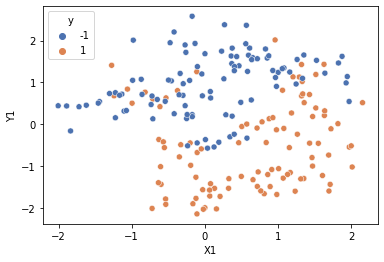

In [323]:
Data = pd.concat([df1,df2])
Data.columns=['X1','Y1','y']
sns.scatterplot(data=Data,x='X1',y='Y1',hue="y", palette='deep')

Splitting dataset in input and target array

In [324]:
X_train = Data.iloc[:, :-1].values
y_train = Data.iloc[:, -1].values
y_train[y_train==-1]=0

Node Class

In [325]:
class Node:
    def __init__(self, axis=None, split=None, left=None, right=None, label=None):
        self.axis = axis            # axis used for splitting
        self.split = split          # split point for the feature
        self.left = left            # left child node
        self.right = right          # right child node
        self.label = label          # label for leaf nodes

Tree Class

In [326]:
class ClassificationTree:        
    def misclassification_rate(self, y):
        # Calculating the misclassification rate
        n = len(y)
        counts = np.bincount(y)
        if(len(counts)!=0):
          return 1 - np.max(counts) / n
        else:
          return 0
    
    def best_split(self, X, y):
        # Find the best feature and split point for splitting the dataset
        best_axis, best_split, best_misclassification_rate = None, None, np.inf
        
        for i in range(X.shape[1]):
            feature_values = np.unique(X[:, i])
            if len(feature_values) == 1:  # Skip if only one unique value
              continue
            for split in feature_values:
                y_left = y[X[:, i] <= split]
                y_right = y[X[:, i] > split]
                misclassification_rate = (len(y_left) * self.misclassification_rate(y_left) + 
                                          len(y_right) * self.misclassification_rate(y_right)) / len(y)
                
                if misclassification_rate < best_misclassification_rate:
                    best_axis, best_split, best_misclassification_rate = i, split, misclassification_rate
        
        return best_axis, best_split, best_misclassification_rate
        
    def _split(self, X, y, depth, max_depth):
        if depth >= max_depth or len(np.unique(y)) <= 1 :
            return Node(label=np.bincount(y).argmax())
        
        axis, split, misclassification_rate = self.best_split(X, y)
        if split is None:
          return Node(value=np.mean(y))
        # Recursively split the dataset until a stopping criterion is met
        left = self._split(X[X[:, axis] <= split], y[X[:, axis] <= split], depth+1, max_depth)
        right = self._split(X[X[:, axis] > split], y[X[:, axis] > split], depth+1, max_depth)
        return Node(axis=axis, split=split, left=left, right=right)
    
def predict(X, tree):
    # Make a prediction for each sample in x
      predictions = []
      for sample in X:
          node = tree
          while node.label is None:
              if sample[node.axis] <= node.split:
                  node = node.left
              else:
                  node = node.right
          predictions.append(node.label)
      return np.array(predictions)



Predicting the results

In [327]:
classifier = ClassificationTree()
tree = classifier._split(X_train, y_train, 0, 3)
y_pred = predict(X_train,tree)

print("Accuracy is:", np.mean(y_pred == y_train))  #Printing the accuracy

Accuracy is: 0.855


Plotting the results

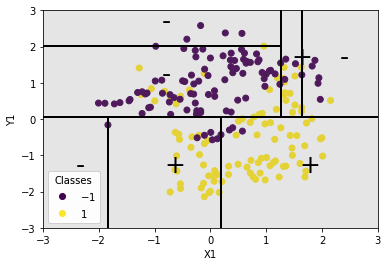

In [328]:
def plot_splits(tree, xmin, xmax, ymin, ymax):
    if tree.label is not None:
        x = np.linspace(xmin, xmax, 100)
        y = np.linspace(ymin, ymax, 100)
        X, Y = np.meshgrid(x, y)
        Z = np.zeros(X.shape)
        Z[:] = tree.label
        plt.contourf(X, Y, Z, alpha=0.2, colors=['gray'])
        if tree.label > 0:
            plt.text((xmin+xmax)/2, (ymin+ymax)/2, '+', fontsize=25)
        else:
            plt.text((xmin+xmax)/2, (ymin+ymax)/2, '-', fontsize=25)
    else:
        if tree.axis == 0:
            plt.vlines(tree.split, ymin, ymax, colors='black', linestyle='-', linewidth=2)
            plot_splits(tree.left, xmin, tree.split, ymin, ymax)
            plot_splits(tree.right, tree.split, xmax, ymin, ymax)
        else:
            plt.hlines(tree.split, xmin, xmax, colors='black', linestyle='-', linewidth=2)
            plot_splits(tree.left, xmin, xmax, ymin, tree.split)
            plot_splits(tree.right, xmin, xmax, tree.split, ymax)


# Plot data points and decision boundaries
fig, ax = plt.subplots()

# scatter plot of the training data
y_train[y_train==0]=-1
scatter = ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

# set axis limits
ax.set_xlim([-3, 3])
ax.set_ylim([-3, 3])

# plot the decision boundary using the tree
plot_splits(tree, -3, 3, -3, 3)

# set axis labels
ax.set_xlabel('X1')
ax.set_ylabel('Y1')

# add a colorbar legend
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)

plt.show()


Finding the training error

In [329]:
y_train[y_train==-1]=0
y_pred = predict(X_train,tree)
error = np.mean(y_pred != y_train)
print(error)

0.145


# **Question 2**

Generation of 500 data points

In [330]:
mean = np.zeros(10)
cov = np.eye(10)

X = np.random.multivariate_normal(mean, cov, 500)

Alloting the value of Yi

In [331]:
#Euclidean norms of the data points
norms = np.linalg.norm(X, ord=2, axis=1)

#Assigning the value of Y based on the given condition
Y = np.ones(500)
for i in range(0,500):
  if(norms[i]**2 < 9.34):
    Y[i]=-1
  else:
    Y[i]=1

Classifying the data

In [332]:
# Dividing the data-set into a training set and a test set
X_train = X[:400]
Y_train = Y[:400]
X_test = X[400:]
Y_test = Y[400:]

# Defining the number of boosting iterations
T = 100

# Initializing the weights of the training set data points
w = np.ones(len(X_train)) / len(X_train)

# Initializing the ensemble
ensemble = []

# Defining the classification function for the two-terminal classification tree
def classify(X, feature_index, threshold):
    return np.where(X[:, feature_index] >= threshold, 1, -1)

# Defining the error function
def error(Y_pred, Y_true, w):
    return np.sum(w * (Y_pred != Y_true))

# Vector for storing the training errors
train_errors = []

# Defining the boosting algorithm
for t in range(T):
    # Training a two-terminal classification tree on the weighted training set
    feature_index = np.random.randint(10)
    threshold = np.random.uniform(-1, 1)
    Y_pred_train = classify(X_train, feature_index, threshold)
    
    # Computing the weighted error rate of the classification tree
    err = error(Y_pred_train, Y_train, w)
    alpha = 0.5 * np.log((1 - err) / err)
    
    # Adding the classification tree to the ensemble
    ensemble.append((alpha, feature_index, threshold))
    
    # Updating the weights of the training set data points
    w = w * np.exp(-alpha * Y_train * Y_pred_train)
    w = w / np.sum(w)
    
    # Computing the error rate on the test set
    Y_pred_test = np.zeros(len(Y_test))
    for alpha_t, feature_index_t, threshold_t in ensemble:
        Y_pred_test += alpha_t * classify(X_test, feature_index_t, threshold_t)
    Y_pred_test = np.sign(Y_pred_test)
    test_error = error(Y_pred_test, Y_test, np.ones(len(Y_test)) / len(Y_test))
    
    # Computing the error rate on the training set
    Y_pred_train = np.zeros(len(Y_train))
    for alpha_t, feature_index_t, threshold_t in ensemble:
        Y_pred_train += alpha_t * classify(X_train, feature_index_t, threshold_t)
    Y_pred_train = np.sign(Y_pred_train)
    train_error = error(Y_pred_train, Y_train, np.ones(len(Y_train)) / len(Y_train))
    train_errors.append(train_error)
    
    print(f"Iteration {t+1}: Test error = {test_error:.3f}, Train error = {train_error:.3f}")


Iteration 1: Test error = 0.490, Train error = 0.490
Iteration 2: Test error = 0.500, Train error = 0.483
Iteration 3: Test error = 0.380, Train error = 0.455
Iteration 4: Test error = 0.380, Train error = 0.455
Iteration 5: Test error = 0.450, Train error = 0.463
Iteration 6: Test error = 0.440, Train error = 0.458
Iteration 7: Test error = 0.460, Train error = 0.440
Iteration 8: Test error = 0.440, Train error = 0.453
Iteration 9: Test error = 0.400, Train error = 0.465
Iteration 10: Test error = 0.410, Train error = 0.458
Iteration 11: Test error = 0.380, Train error = 0.428
Iteration 12: Test error = 0.370, Train error = 0.430
Iteration 13: Test error = 0.370, Train error = 0.432
Iteration 14: Test error = 0.370, Train error = 0.427
Iteration 15: Test error = 0.360, Train error = 0.427
Iteration 16: Test error = 0.370, Train error = 0.443
Iteration 17: Test error = 0.410, Train error = 0.435
Iteration 18: Test error = 0.390, Train error = 0.438
Iteration 19: Test error = 0.410, Tra

Plotting the training error

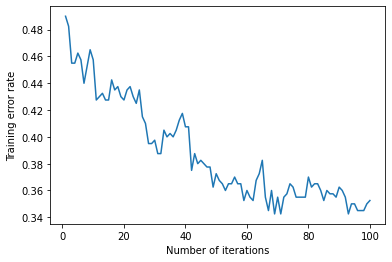

In [333]:
plt.plot(range(1, T+1), train_errors)
plt.xlabel("Number of iterations")
plt.ylabel("Training error rate")
plt.show()

# **Question 3**

Importing built-in libraries for Question 3

In [334]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor

Converting the words to numbers

In [335]:
# Load the data from CSV file
data = pd.read_csv("sample_data/Carseats.csv")

#Replacing the words with the respective numbers
data.replace({'Good': 1, 'Medium': 0, 'Bad': -1, 'Yes': 1, 'No': 0}, inplace=True)

# Saving the modified dataframe back to CSV file
data.to_csv("sample_data/Carseats_modified.csv", index=False)


Question 3(a). Splitting the data into training and test data

In [336]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data.to_csv("sample_data/Carseats_train.csv", index=False)
test_data.to_csv("sample_data/Carseats_test.csv", index=False)
X_train = train_data.drop('Sales', axis=1)
y_train = train_data['Sales']
X_test = test_data.drop('Sales', axis=1)
y_test = test_data['Sales']

Question 3(b). Binary tree using regression method

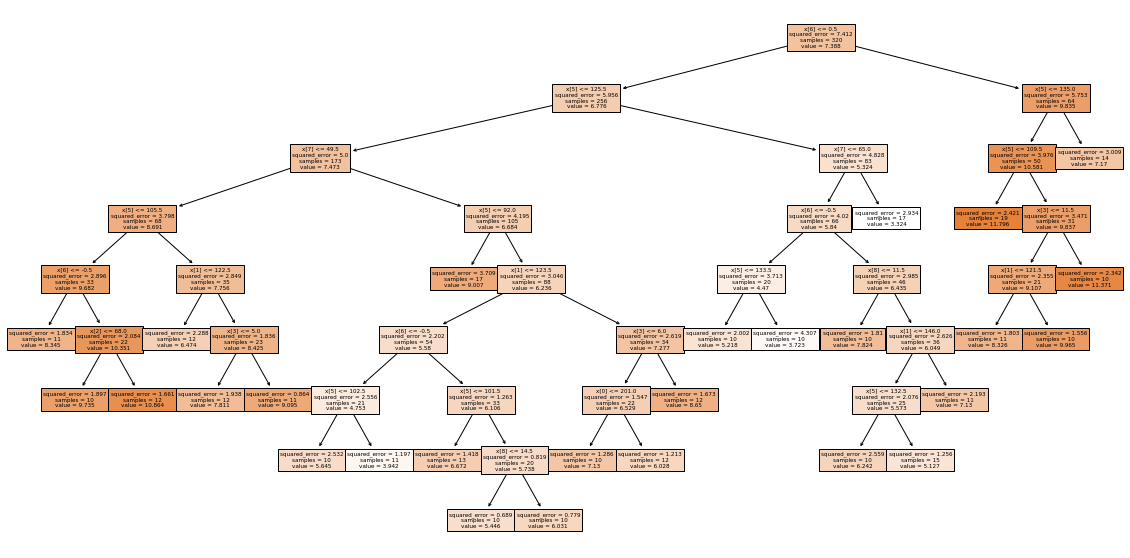

In [337]:
#Fitting the tree on the training dataset
tree = DecisionTreeRegressor(min_samples_leaf=10)
tree.fit(X_train, y_train)

# Visualising the tree
plt.figure(figsize=(20,10))
plot_tree(tree, filled=True)
plt.show()

Finding the test error

In [338]:
test_error = tree.score(X_test, y_test)
print(f'Test error: {test_error:.2f}')

Test error: 0.54


Question 3(c). Cost Complexity pruning

In [339]:
path = tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Training the decision tree for each value of alpha

In [340]:
test_errors = []
for ccp_alpha in ccp_alphas:
    tree = DecisionTreeRegressor(min_samples_leaf=10, ccp_alpha=ccp_alpha)
    tree.fit(X_train, y_train)
    test_error = tree.score(X_test, y_test)
    test_errors.append(test_error)

Finding the optimum value of alpha

In [341]:
best_ccp_alpha = ccp_alphas[np.argmax(test_errors)]
print(f'Best ccp_alpha: {best_ccp_alpha:.2f}')


Best ccp_alpha: 0.01


Training the decision tree with this value of alpha

In [342]:
tree = DecisionTreeRegressor(min_samples_leaf=10, ccp_alpha=best_ccp_alpha)
tree.fit(X_train, y_train)
test_error = tree.score(X_test, y_test)
print(f'Test error: {test_error:.2f}')


Test error: 0.55


Visualising the constructed tree

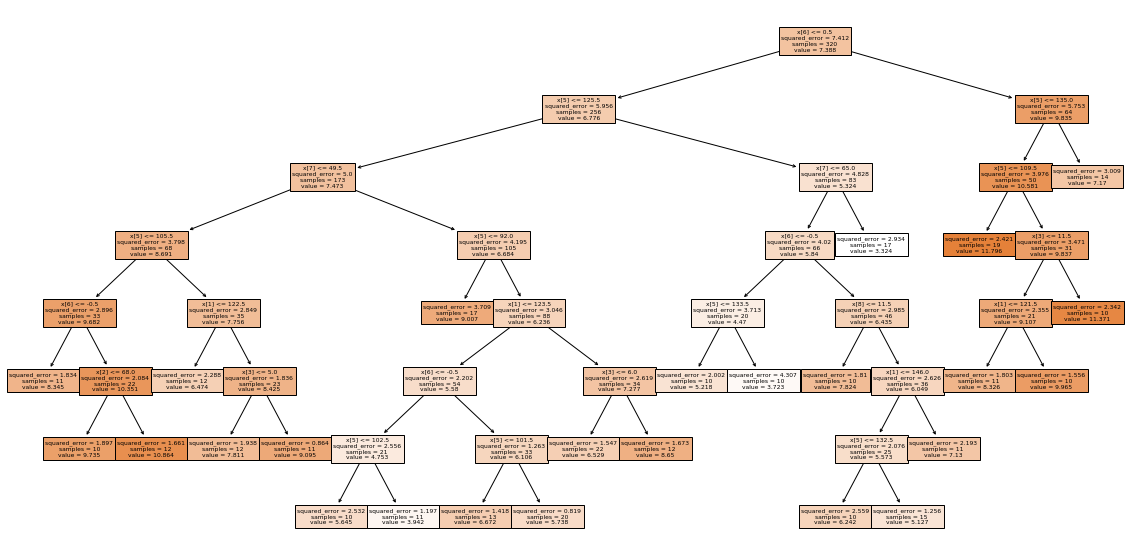

In [310]:
plt.figure(figsize=(20,10))
plot_tree(tree, filled=True)
plt.show()

Question 3(d). Building a random forest


Selecting a random subset of rows from the training dataset

In [311]:
n_samples = len(X_train)
subset_indices = np.random.choice(n_samples, size=n_samples//4, replace=False)
X_subset = X_train.iloc[subset_indices]
y_subset = y_train.iloc[subset_indices]


Defining the hyper-parameters for the random forest

In [312]:
n_estimators = 100
max_depth = None
max_features = 4


Fitting the random forest

In [313]:
rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features)
rf.fit(X_subset, y_subset)
test_error = rf.score(X_test, y_test)
print(f'Test error: {test_error:.2f}')


Test error: 0.43
